In [560]:
import numpy as np
import matplotlib.pyplot as plt
from galpy.util import bovy_coords, bovy_conversion, multi, bovy_plot
from galpy.orbit import Orbit
from galpy.potential import MovingObjectPotential,PlummerPotential,ChandrasekharDynamicalFrictionForce,plotRotcurve,vcirc
from astropy import units as u
%pylab inline

Populating the interactive namespace from numpy and matplotlib
/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['angle', 'time', 'copy', 'grid', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"



$\textbf{This is a tutorial on orbits interacting with non-axisymmetric structures and external perturbers (by Jason Hunt)}$

Adrian's orbit workshop already covered a lot of the theory of orbits, orbit integration and potentials, so here we just assume this is known. You should do his first if you haven't!

There are (to my knowledge) three main Galactic dynamics packages for python: Galpy, Gala and Agama. They all have their individual strengths and weaknesses which will be covered by Adrian on Friday! At their core, they can all handle various gravitational potentials, orbit integration and parameter estimation.

https://github.com/jobovy/galpy (Bovy 2015, ApJS, 216, 29)

https://github.com/adrn/gala (Price-Whelan 2017, The  Journal  of  Open  Source Software, 2, 388)

https://github.com/GalacticDynamics-Oxford/Agama (Vasiliev 2019, MNRAS, 482, 1525)

This workshop/tutorial will be in the galactic dynamics package Galpy, to give some variety in the options available compared to yesterday. Feel to convert any of the cells to your preferred package if you are already an experienced user

While this tutorial is in Galpy, it's worth remembering we have the author of Gala here at the school (Adrian) so you may want to make use of him in your later project work!

Finally, there are a few '$\textbf{exercises}$' and a few '$\textbf{stretch goal exercises}$' scattered below. Please have a go at the 'exercises' as you go! They should be directly related to examples from other cells. 

It's OK if you don't finish everything, hopefully this will provide some useful examples for your future work. It's also OK if you get stuck, have a go yourself at things first, but ask for help if it's not working. Your mentors and your peers will be happy to help!

If you do finish the whole notebook go back and pick from the stretch goals, whatever you find most interesting. They will require more effort, and some new coding!

If you manage to finish the stretch goals, wow well done you! Please go and help your peers :)

$\textbf{Example: Potentials}$

Like Gala, Galpy has several pre-built potentials for you to make use of 

(https://docs.galpy.org/en/v1.6.0/reference/potential.html#potential-api)

To start we need a potential for the Milky Way. The standard 'Milky Way like' potential in Galpy is MWPotential2014 which is fit to various observational constraints  

Several other Milky Way like potenitals exist, and can be found at https://docs.galpy.org/en/v1.6.0/reference/potential.html#milky-way-like-potentials

But, for simplicity we'll mainly stick with MWPotential2014 (and varients of it) in this notebook. MWPotential2014 is a list of potential components comprised of a Power Sphere bulge, a Miyamoto Nagai disc and a NFW halo potential

We can just import the pre-built version:

In [2]:
from galpy.potential import MWPotential2014

We can plot the rotation curve for the potential in full, or examine the individual components with their list index.

Note: Galpy uses internal length units of $R_0$, which is the Solar radius (set to 8 kpc as default) and $v_0$, which is the circular velocity at $R_0$ (set to 220 km s$^{-1}$ by default), such that the Sun is at $R/R_0=1$, and $v_{\mathrm{circ}}/v_0=1$ at $R/R_0=1$. 

1.0
0.9217689827585458


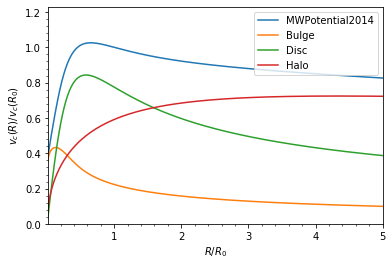

In [3]:
plotRotcurve(MWPotential2014,label='MWPotential2014')
plotRotcurve(MWPotential2014[0],overplot=True,label='Bulge')
plotRotcurve(MWPotential2014[1],overplot=True,label='Disc')
plotRotcurve(MWPotential2014[2],overplot=True,label='Halo')
plt.legend();

print(vcirc(MWPotential2014,1)) # Get the circular velocity as R/R0=1 (the Solar radius) shows v_circ=1
print(vcirc(MWPotential2014,2)) # At 2 Rsun (16 kpc), it's less owing to the falling rotation curve

Alternatively, we can construct out own "Milky Way-like" potential by combining different components.

Note that the normalize values should add up to 1. such that the circular velocity will be 1 at R=1. 

Here's an example with a flat rotation curve, feel free to change the parameters below and see what you get. We won't use this one again so don't worry if you break it ;) The docs for each part of the potential are below, so you can see what the parameters will change:

https://docs.galpy.org/en/v1.6.0/reference/potentialmiyamoto.html

https://docs.galpy.org/en/v1.6.0/reference/potentialnfw.html

https://docs.galpy.org/en/v1.6.0/reference/potentialhernquist.html

In [4]:
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential

mp= MiyamotoNagaiPotential(a=0.5,b=0.0375,normalize=.6)
nfp= NFWPotential(a=4.5,normalize=.35)
hp= HernquistPotential(a=0.6/8,normalize=0.05)
pot=hp+mp+nfp # Or equivalently pot=[mp,np,hp]

1.0
0.9896889180519812


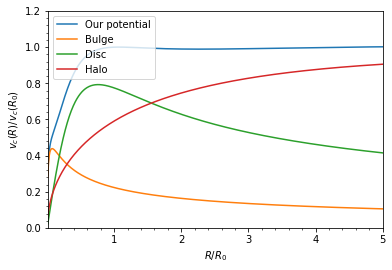

In [5]:
plotRotcurve(pot,label='Our potential')
plotRotcurve(pot[0],overplot=True,label='Bulge')
plotRotcurve(pot[1],overplot=True,label='Disc')
plotRotcurve(pot[2],overplot=True,label='Halo')
plt.legend();

print(vcirc(pot,1)) 
print(vcirc(pot,2)) # For my values, it's now closer to flat, as you can see from the plot below. 

You can also evaluate the potential, or density values at specific points, and visualise them

-1.3733506513947895
-4.552578040219292


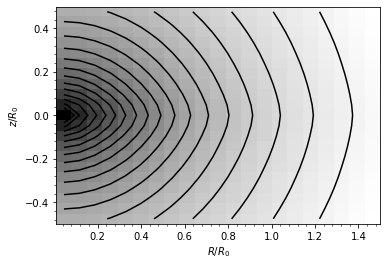

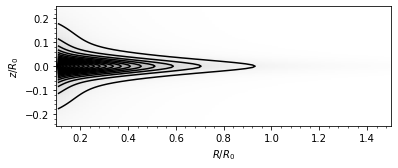

In [537]:
from galpy.potential import evaluatePotentials, plotPotentials, plotDensities

print (evaluatePotentials(MWPotential2014,1.,0.)) # Evaluate at R=1, z=0
print (evaluatePotentials(pot,1.,0.))
plotPotentials(MWPotential2014,rmin=0.01,aspect='equal');
plotDensities(MWPotential2014,rmin=0.1,zmax=0.25,zmin=-0.25,nrs=101,nzs=101,aspect='equal');

$\textbf{Example: Orbit integration}$ 

Now that we have a potential for our galaxy, we can integrate some orbits in it. 

You can set orbit parameters yourself in an array of [$R,v_R,v_{\phi},z,v_z,\phi$]



But, as above, they must be in natural units, so divide physical values by 8 or 220 for position or velocities

There are many other ways to initialise an orbit instance in varying coordinate systems (including astropy's skycoord), see doc's below

(https://docs.galpy.org/en/v1.6.0/reference/orbitinit.html)

(https://docs.galpy.org/en/v1.6.0/orbit.html#initialization-from-observed-coordinates-or-astropy-skycoord)

In [7]:
# For example, the coordinates of the Sagittarius dwarf galaxy from Vasiliev (2020) in cylindrical coordinates
R=17.68
vR=232.07
vphi=57.7
z=-6.5
vz=209.0
phi=3.0

ro=8.
vo=220.

Sgr_Vas=Orbit(vxvv=[R/ro,vR/vo,vphi/vo,z/ro,vz/vo,phi])

Alternatively, you can initialise orbits for any named object from the Simbad data service 

(Note that Orbits initialized using Orbit.from_name have physical output turned on by default, so methods will return outputs in physical units unless you do Sgr_sim.turn_physical_off() which we won't here.)

In [8]:
Sgr_Sim=Orbit.from_name('SDG') # Where, for example, SDG is the Sagittarius dwarf galaxy

Now, can we integrate them backwards in time and see where Sagittarius came from?...

We need a 'time' array to tell us how long to go for, and the timesteps, and we need a potential in which to calculate the orbits

In [9]:
# Let's go back 4 Gyr, in 1000 steps. Again, we need to convert into internal Galpy units

time=np.linspace(0,-4.0/bovy_conversion.time_in_Gyr(220.,8.),1000)

Sgr_Vas.integrate(time,MWPotential2014)
Sgr_Sim.integrate(time,MWPotential2014)

And let's take a look at the orbits:

You can plot a variety of orbital parameters (see link to docs)

(https://docs.galpy.org/en/v1.6.0/reference/orbit.html)

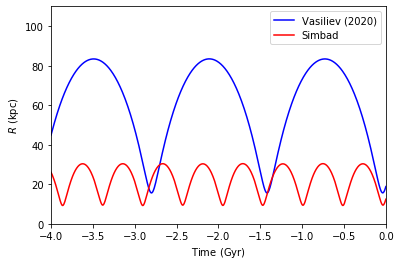

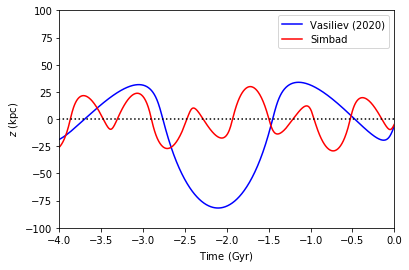

In [10]:
# An example of the orbits in R and z
# Note that the 'from name' routine is (inconsistently) already in physical units 

plt.figure()
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Vas.r(time)*ro,label='Vasiliev (2020)',color='blue')
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Sim.r(time),label='Simbad',color='red')
plt.xlim(-4,0)
plt.ylim(0,110)
plt.xlabel(r'$\mathrm{Time\ (Gyr)}$')
plt.ylabel(r'$R\ (\mathrm{kpc})$')
plt.legend()
plt.show()

plt.figure()
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Vas.z(time)*ro,label='Vasiliev (2020)',color='blue')
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Sim.z(time),label='Simbad',color='red')
plt.plot([-7,7],[0,0],ls=':',color='k')
plt.xlim(-4,0)
plt.ylim(-100,100)
plt.xlabel(r'$\mathrm{Time\ (Gyr)}$')
plt.ylabel(r'$z\ (\mathrm{kpc})$')
plt.legend()
plt.show()

Even in the same galactic potential, the difference in initial conditions makes a significant effect on the resulting orbit!  

$\textbf{Example: Dynamical Friction}$

However, we are still missing an important part of the orbital modelling, which is dynamical friction

To implement dynamical friction we need a mass and density profile for the dwarf galaxy (and the host galaxy)

(https://docs.galpy.org/en/v1.6.0/reference/potentialchandrasekhardynfric.html)

In [11]:
cdf=ChandrasekharDynamicalFrictionForce(GMs=1e10*u.Msun,rhm=8.*u.kpc,dens=MWPotential2014)

And now let's integrate the orbits with dynamical friction included

You can add the 'cdf' potential object to the MWPotential2014 list

(You can ignore the warnings, a lot of the potential integration is done in C, but not implemented for the dynamical friction force so it's falling back on python)

In [12]:
Sgr_Vas_DF=Orbit(vxvv=[R/ro,vR/vo,vphi/vo,z/ro,vz/vo,phi])
Sgr_Sim_DF=Orbit.from_name('SDG')

Sgr_Vas_DF.integrate(time,MWPotential2014+cdf)
Sgr_Sim_DF.integrate(time,MWPotential2014+cdf)

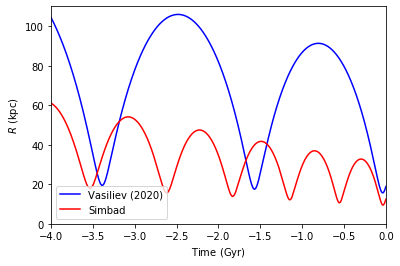

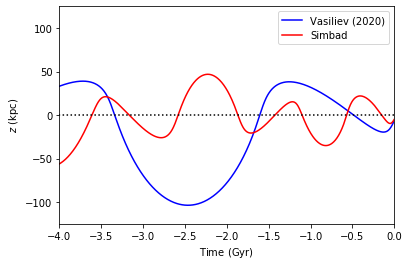

In [13]:
plt.figure()
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Vas_DF.r(time)*ro,label='Vasiliev (2020)',color='blue')
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Sim_DF.r(time),label='Simbad',color='red')
plt.xlim(-4,0)
plt.ylim(0,110)
plt.xlabel(r'$\mathrm{Time\ (Gyr)}$')
plt.ylabel(r'$R\ (\mathrm{kpc})$')
plt.legend()
plt.show()

plt.figure()
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Vas_DF.z(time)*ro,label='Vasiliev (2020)',color='blue')
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Sim_DF.z(time),label='Simbad',color='red')
plt.plot([-7,7],[0,0],ls=':',color='k')
plt.xlim(-4,0)
plt.ylim(-125,125)
plt.xlabel(r'$\mathrm{Time\ (Gyr)}$')
plt.ylabel(r'$z\ (\mathrm{kpc})$')
plt.legend()
plt.show()

$\textbf{An exersise for you:}$ Play around with the mass and half-mass radius of the satellite in the example cell below and see how the change in dynamical friction affects the orbit. This isn't supposed to be difficult coding, but to help you build intuition about the infall

So, before you start, how do you think a more massive satellite will fall in to the MW?

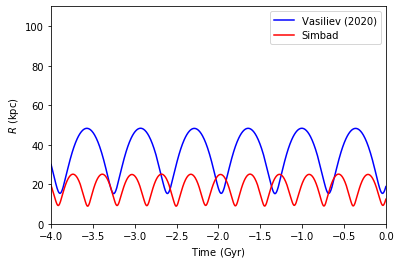

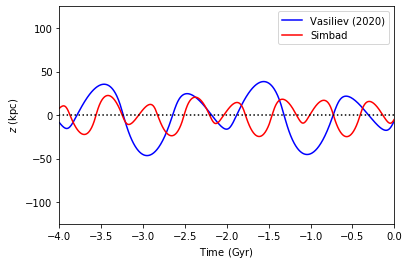

In [539]:
cdf2=ChandrasekharDynamicalFrictionForce(GMs=100*u.Msun,rhm=0.01*u.kpc,dens=MWPotential2014)

Sgr_Vas_DF2=Orbit(vxvv=[R/ro,vR/vo,vphi/vo,z/ro,vz/vo,phi])
Sgr_Sim_DF2=Orbit.from_name('SDG')

Sgr_Vas_DF2.integrate(time,pot+cdf2)
Sgr_Sim_DF2.integrate(time,pot+cdf2)

plt.figure()
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Vas_DF2.r(time)*ro,label='Vasiliev (2020)',color='blue')
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Sim_DF2.r(time),label='Simbad',color='red')
plt.xlim(-4,0)
plt.ylim(0,110)
plt.xlabel(r'$\mathrm{Time\ (Gyr)}$')
plt.ylabel(r'$R\ (\mathrm{kpc})$')
plt.legend()
plt.show()

plt.figure()
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Vas_DF2.z(time)*ro,label='Vasiliev (2020)',color='blue')
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Sim_DF2.z(time),label='Simbad',color='red')
plt.plot([-7,7],[0,0],ls=':',color='k')
plt.xlim(-4,0)
plt.ylim(-125,125)
plt.xlabel(r'$\mathrm{Time\ (Gyr)}$')
plt.ylabel(r'$z\ (\mathrm{kpc})$')
plt.legend()
plt.show()

In addition, the halo potential in MWPotential2014 in known to be on the lower end of mass estimates for the Milky Way's dark matter halo

Because the potential is a list of components, you can increase the mass of the halo by multiplying that part of the potential (but let's make a copy so we don't lose the original)

As suggested in the Galpy documentation, increasing the halo mass by 50% brings it more in line with recent measurements

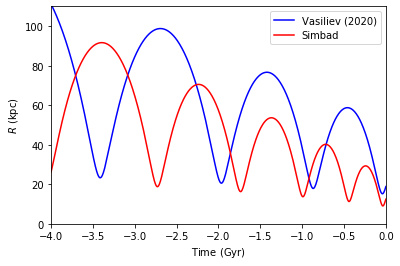

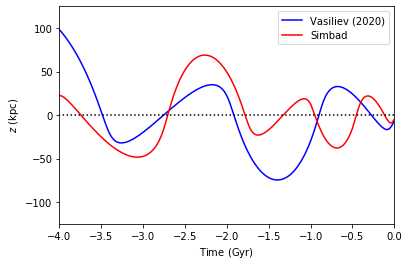

In [15]:
import copy

MWPotential2014_heavy=copy.deepcopy(MWPotential2014)
MWPotential2014_heavy[2]*=1.5

cdf3=ChandrasekharDynamicalFrictionForce(GMs=1e10*u.Msun,rhm=1.*u.kpc,dens=MWPotential2014_heavy)

Sgr_Vas_DF2=Orbit(vxvv=[R/ro,vR/vo,vphi/vo,z/ro,vz/vo,phi])
Sgr_Sim_DF2=Orbit.from_name('SDG')

Sgr_Vas_DF2.integrate(time,MWPotential2014_heavy+cdf3)
Sgr_Sim_DF2.integrate(time,MWPotential2014_heavy+cdf3)

plt.figure()
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Vas_DF2.r(time)*ro,label='Vasiliev (2020)',color='blue')
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Sim_DF2.r(time),label='Simbad',color='red')
plt.xlim(-4,0)
plt.ylim(0,110)
plt.xlabel(r'$\mathrm{Time\ (Gyr)}$')
plt.ylabel(r'$R\ (\mathrm{kpc})$')
plt.legend()
plt.show()

plt.figure()
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Vas_DF2.z(time)*ro,label='Vasiliev (2020)',color='blue')
plt.plot(time*bovy_conversion.time_in_Gyr(220.,8.),Sgr_Sim_DF2.z(time),label='Simbad',color='red')
plt.plot([-7,7],[0,0],ls=':',color='k')
plt.xlim(-4,0)
plt.ylim(-125,125)
plt.xlabel(r'$\mathrm{Time\ (Gyr)}$')
plt.ylabel(r'$z\ (\mathrm{kpc})$')
plt.legend()
plt.show()

In addition, an actual satellite falling into the Milky Way will be losing mass, which we did not account for here in the dynamical friction force calculation. Take a moment to consider how that would change the infall?

So, considering the variation in the orbits for our levels of uncertainty, and the lack of mass loss, how much do we trust our orbits here?... Perhaps it's better we don't talk about that! 

Regardless, moving forwards we can select a Fiducial orbit for the rest of the notebook. In the rest of the infall examples I pick Vasiliev's initial conditions, the heavier halo, and set GMs=5e8 M$_{\odot}$ and rhm=5 kpc

Feel free to select a different one going forwards, and perhaps choose different values and compare with other students! Or come back here later and run through things with a different orbit/potential

$\textbf{Stretch goal exersise: Correct for the mass loss}$

e.g. see CDF doc page above, but you have to manually edit the mass and integrate segments of the orbits separately
- Come up with some mass loss scheme, you can assume a flat relation for simplicity, or look at Vasiliev's 2020 paper for an estimation
- Compute the orbit in fragments changing the mass
- Compare to the fixed mass orbit

$\textbf{Example: The effect of the dwarf on stellar orbits}$

So far we were only examining the orbit of Sgr in a Milky Way-like potential. However, as the dwarf falls in, it will also have an impact on the stars (and dark matter) in our galaxy.

We'll take a look at the effect on a few disc stars. First, let's set up a multi-star orbit object, similar to above (Feel free to edit the numbers to make your own unique orbits, but remember they must be in internal units!)



In [554]:
# Set up an array of N individual orbits (these are random, feel free to edit. Each is [R,vR,vphi,z,vz,phi] in normalised units)
vxvvs=numpy.array([[1.,0.1,1.,0.1,-0.2,1.5],[0.1,0.3,1.1,-0.3,0.4,2.],[0.2,0.3,1.1,-0.3,0.4,2.],[1.,0.3,1.1,-0.3,0.4,2.],[0.5,0.3,1.1,-0.3,0.4,2.]])
# Turn them into an orbit object
orbits= Orbit(vxvvs)



Then, we integrate them similar to how we did the satellite, except this time, let's go forward in time from -4 to 0

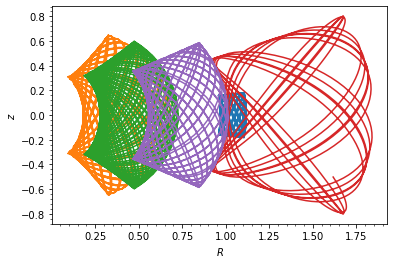

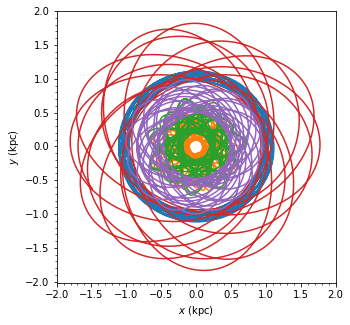

In [555]:
# Integrate it 
time2=np.linspace(-4.0/bovy_conversion.time_in_Gyr(220.,8.),0.,1000)
orbits.integrate(time2,MWPotential2014)

# The 'orbit' class also has plotting functionality built in. Default is R-z
orbits.plot();

# You can set other dimensions manually
plt.figure(figsize=(5,5))
orbits.plot(d1='x',d2='y',overplot=True);
plt.xlim(-2,2)
plt.xlabel(r'$x\ (\mathrm{kpc})$');
plt.ylabel(r'$y\ (\mathrm{kpc})$');

You can also animate the orbits (although it's a little slow...)

It should work for any of the orbit properties, as described above

Try hovering over the graph once you've it's done!

In [79]:
orbits.animate(d1=['x','R'],d2=['y','z'],width=800)

They are nice and regular!

Now, let's put Sagittarius along the orbit we computed earlier, and see what it does to them?

Firstly, we need a potential object for the dwarf galaxy itself. We'll use a Plummer Sphere:

(https://docs.galpy.org/en/v1.6.0/reference/potentialplummer.html)

In [523]:
plum=PlummerPotential(amp=5e9*u.Msun, b=5.*u.kpc)

Now, let's initialise another Sagittarius orbit and make a 'moving object potential' where we let the plummer sphere follow the orbital path

The moving object potential can be used to make any galpy potential object follow along any galpy orbit instance

(https://docs.galpy.org/en/latest/reference/potentialmovingobj.html)

In [524]:
# Set up the next orbit
cdf4=ChandrasekharDynamicalFrictionForce(GMs=5e9*u.Msun,rhm=5.*u.kpc,dens=MWPotential2014_heavy)
Sgr_Vas_DF4=Orbit(vxvv=[R/ro,vR/vo,vphi/vo,z/ro,vz/vo,phi])
Sgr_Vas_DF4.integrate(time,MWPotential2014_heavy+cdf4)

satpot=MovingObjectPotential(Sgr_Vas_DF4,plum)

Now, let's integrate those same orbits again in the time evolving potential and see what Sgr has done!

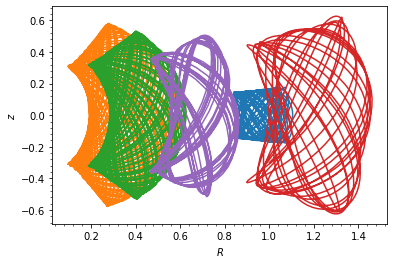

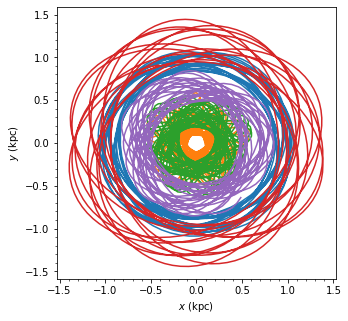

In [525]:
# Turn them into an orbit object
perturbed_orbits= Orbit(vxvvs)
# Integrate it
perturbed_orbits.integrate(time2,MWPotential2014_heavy+satpot)

# The 'orbit' class also has plotting functionality built in. Default is R-z
perturbed_orbits.plot();

# You can set other dimensions
plt.figure(figsize=(5,5))
perturbed_orbits.plot(d1='x',d2='y',overplot=True);
plt.xlabel(r'$x\ (\mathrm{kpc})$');
plt.ylabel(r'$y\ (\mathrm{kpc})$');

Ok, that wasn't much was it! (although they are now not completely regular) But most of these stars from my demo orbits are in the inner galaxy... You may have had something more dramatic if you edited the orbits

$\textbf{Exersise: What if Sgr was 10 times more massive?}$

Using the above cells, you should be able to redo this with a heavier dwarf, and call it more_perturbed_orbits to work with the below cells

In [543]:
# Set up the next dwarf
# Set up the new orbit
# Create the moving object pot
# Initialise the orbit object
# Integrate it
# Plot it
# If interesting, animate it! If not interesting, try different orbits/perturbers

Let's check the energy for these orbits, as discussed in Adrian's orbit workshop (and Helmer's upcoming one) and see the change (note that 'more_perturbed_orbits' is my heavier Sgr orbit instance which I have taken out!)

The energy for the non-interacting case should be (effectively) constant

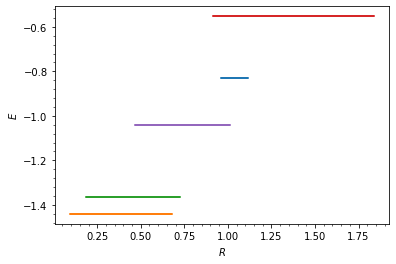

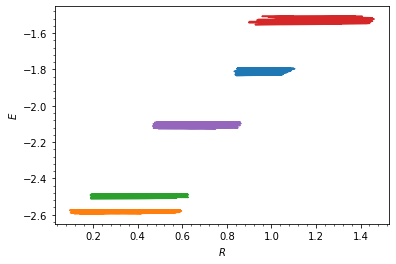

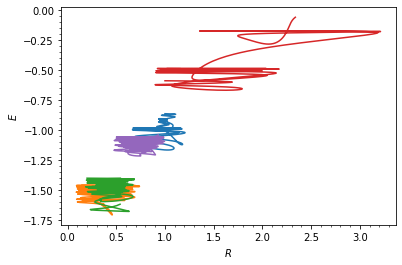

In [172]:
orbits.plot(d1='R',d2='E');
perturbed_orbits.plot(d1='R',d2='E');
more_perturbed_orbits.plot(d1='R',d2='E');

For the perturbed cases you can see the impacts of Sgr in the orbital energy. The larger the dwarf, the larger the change in energy:

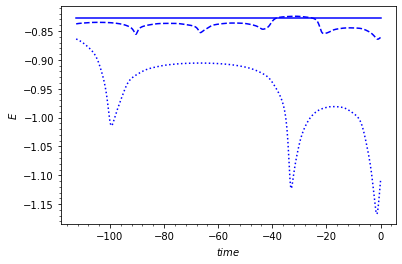

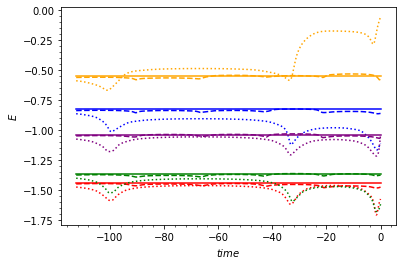

In [148]:
carray=['blue','red','green','orange','purple']

# Plot just the first one 
orbits.plot(d1='time',d2='E',color=carray[0])
perturbed_orbits.plot(d1='time',d2='E',overplot=True,color=carray[0],ls='--')
more_perturbed_orbits.plot(d1='time',d2='E',overplot=True,color=carray[0],ls=':')

# Plot all five
for i in range(0,5):
    if i==0:
        orbits[i].plot(d1='time',d2='E',color=carray[i])
    else:
        orbits[i].plot(d1='time',d2='E',overplot=True,color=carray[i])
    perturbed_orbits[i].plot(d1='time',d2='E',overplot=True,color=carray[i],ls='--')
    more_perturbed_orbits[i].plot(d1='time',d2='E',overplot=True,color=carray[i],ls=':')

Now we know how to integrate and examine multiple objects, let's do some real ones from the MW

The Orbit.from_name method also allows you to load some collections of objects in a simple manner. Currently, three collections are supported: ‘MW globular clusters’, ‘MW satellite galaxies’, and ‘solar system’. 

We'll make use of the Orbit.from_name routine again to get all of the Milky-Way globular clusters with data from Gaia DR2 (using the Vasiliev 2019 catalog):

In [527]:
GC_orbits= Orbit.from_name('MW globular clusters')
print(GC_orbits.name)

['NGC5286', 'Terzan12', 'Arp2', 'NGC5024', 'NGC6638', 'Crater', 'BH261', 'NGC6553', 'NGC6749', 'NGC6528', 'NGC4372', 'NGC2808', 'IC4499', 'BH229', 'NGC6642', 'NGC6779', 'NGC6541', 'NGC6441', 'Pal4', 'NGC6341', 'NGC5694', 'NGC2298', 'Ton2', 'NGC6637', 'NGC6325', 'NGC4147', 'NGC6366', 'Pal7', 'NGC5986', 'NGC5927', 'Terzan1', 'NGC4833', 'Pal8', 'NGC7078', 'NGC6517', 'NGC6284', 'Pal14', 'NGC6539', 'NGC7089', 'NGC5272', 'NGC362', 'NGC6144', 'NGC6287', 'E3', 'NGC6205', 'NGC6402', 'FSR1735', 'Pal3', 'NGC6256', 'NGC6342', 'Djorg2', 'NGC6093', 'NGC5139', 'Terzan5', 'NGC6333', 'NGC6934', 'NGC6101', 'NGC6171', 'NGC5466', 'Pal5', 'ESO45211', 'NGC6266', 'Pal15', 'Pal13', 'Terzan2', 'NGC6540', 'Terzan4', 'BH184', 'NGC5053', 'NGC6723', 'FSR1716', 'BH176', 'NGC6809', 'NGC5897', 'NGC6496', 'NGC6715', 'NGC6388', 'Pal2', 'NGC1261', 'NGC6362', 'Whiting1', 'NGC6522', 'NGC6254', 'NGC6535', 'NGC6440', 'NGC6316', 'NGC5634', 'NGC7492', 'Terzan9', 'NGC6352', 'Terzan7', 'Terzan6', 'NGC6235', 'NGC5904', 'NGC6626'

<Figure size 432x288 with 0 Axes>

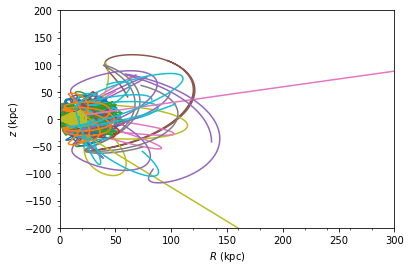

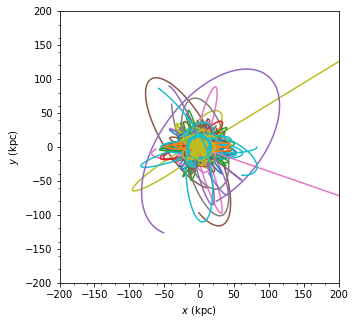

In [529]:
GC_orbits.integrate(time,MWPotential2014_heavy)

plt.figure()
GC_orbits.plot();
plt.xlim(0,300.)
plt.ylim(-200.,200.)

plt.figure(figsize=(5,5))
GC_orbits.plot(d1='x',d2='y',overplot=True);
plt.xlim(-200.,200.)
plt.ylim(-200.,200.)
plt.xlabel(r'$x\ (\mathrm{kpc})$');
plt.ylabel(r'$y\ (\mathrm{kpc})$');


(Or in 3D while we're here...)

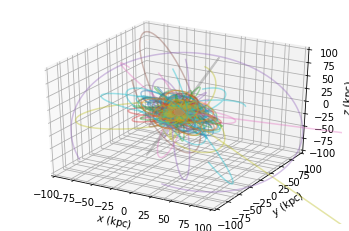

In [181]:
GC_orbits.plot3d(alpha=0.4)
xlim(-100.,100.)
ylim(-100.,100.)
gca().set_zlim3d(-100.,100.);

Some of them are (awkwardly) unbound

This is unlikely to be true, but instead easily explainable by an incorrect potential, or observational error in the cluster orbital parameters

Regardless, what happens if you put Sgr through this lot?

<Figure size 432x288 with 0 Axes>

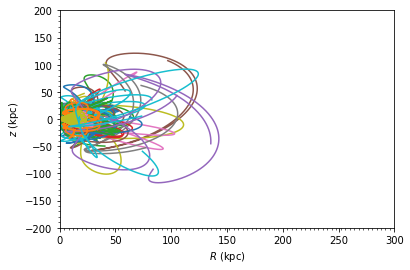

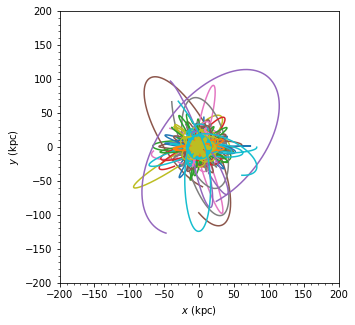

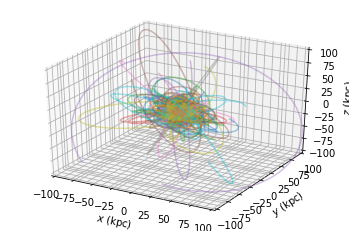

In [530]:
perturbed_GC_orbits= Orbit.from_name('MW globular clusters')
perturbed_GC_orbits.integrate(time,MWPotential2014_heavy+satpot)

plt.figure();
perturbed_GC_orbits.plot();
plt.xlim(0,300.);
plt.ylim(-200.,200.);
plt.show();

plt.figure(figsize=(5,5));
perturbed_GC_orbits.plot(d1='x',d2='y',overplot=True);
plt.xlim(-200.,200.);
plt.ylim(-200.,200.);
plt.xlabel(r'$x\ (\mathrm{kpc})$');
plt.ylabel(r'$y\ (\mathrm{kpc})$');
plt.show();

perturbed_GC_orbits.plot3d(alpha=0.4)
xlim(-100.,100.)
ylim(-100.,100.)
gca().set_zlim3d(-100.,100.);

Now they are not unbound. Hmm. Ok. I wasn't expecting that! The options are:
- A fluke! A complete coincedence, helped by observational error and an uncertain Sgr orbit
- We know there are a bunch of GCs that are related to Sgr. Maybe these are those?
- It could be that some recent interaction with Sgr has set them on their current orbits which not feasible otherwise?

$\textbf{Stretch goal exersise: Track those clusters down! see what they are and where they come from?}$
- Find unbound GCs
- Compare their orbits to Sgr's orbit

$\textbf{Stretch goal exercise from Adrian's idea}: $
- Load the Milky Way dwarf galaxies: You can get them all at once with Orbit.from_name('MW satellite galaxies')
- Calculate their orbits without DF
- Add dynamical friction and redo
- Which ones change and why?
- How about if they were 10x more massive?

$\textbf{Example: Orbits in a barred potential}$

While Sagittarius is a perturbing force that comes from outside our galaxy, there are non-axisymmetric structures that arise in a self-gravitating disc such as a bar or spiral arms, which also effect the orbits of stars in the disc

(Note that it's possible such features are induced by external perturbers, but not required)

To start, we need a potential for our bar. We'll use the DehnenBarPotential which is a simple $m=2$ bar potential visualised below. 

(https://docs.galpy.org/en/latest/reference/potentialdehnenbar.html)

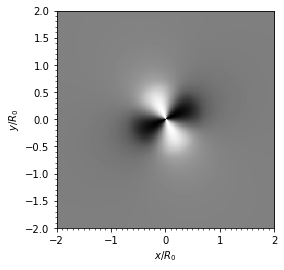

In [545]:
from galpy.potential import DehnenBarPotential 

# We set up our bar parameters. This is a long-slow bar similar to the model of Perez-Villegas et al. (2017)
tform= -10. # number of bar periods in the past that it formed
tsteady= 5. # We grow it slowly over 5 bar periods to avoid 'shocking' the potential 
# (which is completely pointelss here, but vital for other applications so shown for completeness)

omega= 1.3 # Pattern speed of the bar in units of the local circular frequency (220./8=27.5 km/s /kpc)
angle=np.deg2rad(25.) # Bar Angle with respect to the sun (in radians)
length=5. # Half-length of the bar
strength=2.4 # In 'percent of the radial force at the Solar neighborhood'

# Initialise the bar potential, and visualise it
long_bar = DehnenBarPotential(omegab=omega,rb=length/8.,Af=(strength/75.),tform=tform,tsteady=tsteady,barphi=angle)
plotPotentials(long_bar,xy=True,rmin=-2,rmax=2, nrs=200, zmin=-2, zmax=2,ncontours=20,nzs=200,cntrcolors='none',aspect='equal');

# Add it to our MW potential
long_bar_pot = [MWPotential2014,long_bar]

First, let's set up an orbit and just see where that orbit goes without the bar:

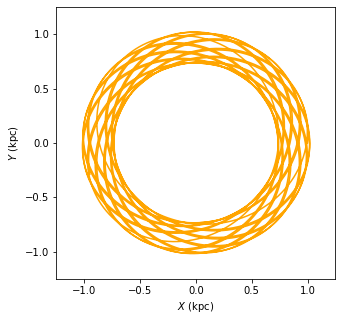

In [515]:
# Set up a particle orbit 
long_bar_orbit1=Orbit(vxvv=[1.,0.1,0.86805,0.,0.0,0.])

# A new time array
long_bar_time=numpy.linspace(0,4./bovy_conversion.time_in_Gyr(vo,ro),10000)

# Integrate
long_bar_orbit1.integrate(long_bar_time,MWPotential2014,method='odeint')

plt.figure(figsize=(5,5))
plt.plot(long_bar_orbit1.x(long_bar_time),long_bar_orbit1.y(long_bar_time),color='orange')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.xlabel(r'$X\ (\mathrm{kpc})$')
plt.ylabel(r'$Y\ (\mathrm{kpc})$')
plt.show()

It's nice and regular! What happens if we do the same in the barred potential?

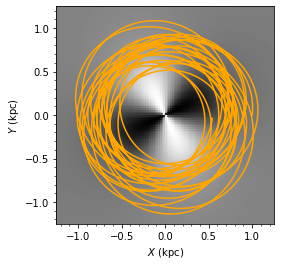

In [535]:
long_bar_orbit2=Orbit(vxvv=[1.,0.1,0.86805,0.,0.0,0.])

long_bar_orbit2.integrate(long_bar_time,long_bar_pot,method='odeint')

plotPotentials(long_bar,xy=True,rmin=-2,rmax=2, nrs=200, zmin=-2, zmax=2,ncontours=20,nzs=200,cntrcolors='none',aspect='equal');
plt.plot(long_bar_orbit2.x(long_bar_time),long_bar_orbit2.y(long_bar_time),color='orange')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.xlabel(r'$X\ (\mathrm{kpc})$')
plt.ylabel(r'$Y\ (\mathrm{kpc})$')
plt.show()

Not so regular anymore! But this orbit is also interesting if we look in the reference frame of the rotating bar.

We know how fast the bar rotates, so we can convert the x-y coordinates into the rotating frame by taking off the bar rotation multiplied by the time

We'll do it for both the unperturbed and perturbed orbit for illustration (even though it only really makes sense if there is a bar!)

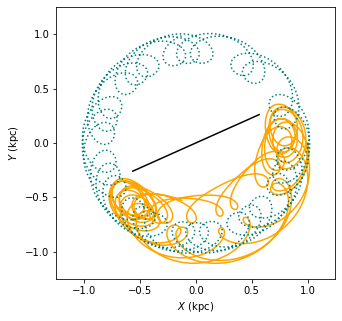

In [513]:
rotation=(long_bar_time*-1.3) # Where 1.3 is the pattern speed, see above

lbx1=long_bar_orbit1.x(long_bar_time)*np.cos(rotation)-long_bar_orbit1.y(long_bar_time)*np.sin(rotation)
lby1=long_bar_orbit1.x(long_bar_time)*np.sin(rotation)+long_bar_orbit1.y(long_bar_time)*np.cos(rotation)

lbx2=long_bar_orbit2.x(long_bar_time)*np.cos(rotation)-long_bar_orbit2.y(long_bar_time)*np.sin(rotation)
lby2=long_bar_orbit2.x(long_bar_time)*np.sin(rotation)+long_bar_orbit2.y(long_bar_time)*np.cos(rotation)

plt.figure(figsize=(5,5))
plt.plot(lbx2,lby2,color='orange')
plt.plot(lbx1,lby1,color='teal',ls='dotted')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.xlabel(r'$X\ (\mathrm{kpc})$')
plt.ylabel(r'$Y\ (\mathrm{kpc})$')

# This is the bar major axis as a black line. 
# It doesn't mean it's thin but feels unnecessary to redraw the potential each time!
plt.plot([-0.566,0.566],[-0.26,0.26],color='black')
plt.show()

Note that while the unperturbed orbit (blue-dotted) covers all azimuth in the rotating frame, the perturbed (red) orbit remains on one side of the bar.

This is because it is close to the bar co-rotation resonance (it's not perfect, Jason just eyeballed it...) and it ends up librating around one of the bar lagrange points (e.g. Perez-Villegas et al. 2017). 

If the bar is long and slow (as in this example) then this resonance will be close to the Solar neighbourhood and could cause substructure in our local kinematics, but there are plenty or other resonances too

For example, the corotation resonance for a rigidly rotating structure with pattern speed $\Omega_{\mathrm{p}}$ occurs when $\Omega_{\mathrm{p}}-\Omega_{\phi}=0$. The inner (ILR) and outer (OLR) 2:1 Lindblad resonances occur when $\Omega_{\mathrm{p}}-\Omega_{\phi}\pm\Omega_{\mathrm{R}}/2=0$, and similarly for the 4:1 ILR and OLR, when $\Omega_{\mathrm{p}}-\Omega_{\phi}\pm\Omega_{\mathrm{R}}/4=0$, and the 1:1 ILR and OLR when $\Omega_{\mathrm{p}}-\Omega_{\phi}\pm\Omega_{\mathrm{R}}=0$ (-ve is outer, +ve is inner for each case)



A commonly examined bar resonance is the OLR. If the bar is short and fast, then this resonance will be close to the Solar neighbourhood instead (e.g. Dehnen 2000). Let's make that bar and see the orbit structure:

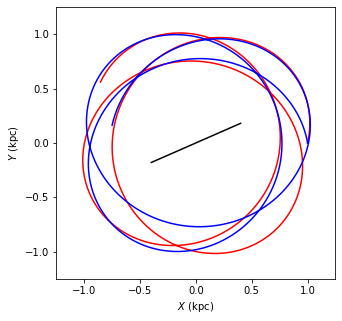

In [399]:
omega = 1.85 # Faster bar
length = 3.5 # Shorter bar
strength = 1. # Less force from the shorter weaker bar!

short_bar = DehnenBarPotential(omegab=omega,rb=length/8.,Af=(strength/75.),tform=tform,tsteady=tsteady,barphi=angle)
short_bar_pot = [MWPotential2014,short_bar]

# We'll set up two orbits this time  (0.153)
short_bar_orbit1=Orbit(vxvv=[1.,0.2,0.9,0.])
short_bar_orbit2=Orbit(vxvv=[1.,-0.15,0.9,0.])

short_bar_time=numpy.linspace(0,0.5/bovy_conversion.time_in_Gyr(vo,ro),1000)

short_bar_orbit1.integrate(short_bar_time,short_bar_pot,method='odeint')
short_bar_orbit2.integrate(short_bar_time,short_bar_pot,method='odeint')

# Plot them in the standard frame
plt.figure(figsize=(5,5))
plt.plot(short_bar_orbit1.x(short_bar_time),short_bar_orbit1.y(short_bar_time),color='red')
plt.plot(short_bar_orbit2.x(short_bar_time),short_bar_orbit2.y(short_bar_time),color='blue')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.xlabel(r'$X\ (\mathrm{kpc})$')
plt.ylabel(r'$Y\ (\mathrm{kpc})$')
plt.plot([-0.4,0.4],[-0.18,0.18],color='black')
plt.show()

And in the rotating frame:

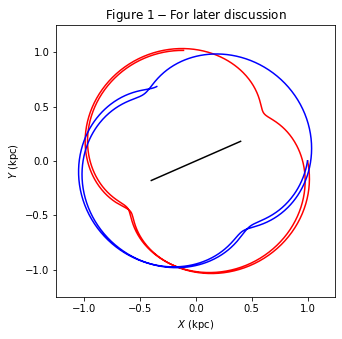

In [586]:
rotation=(short_bar_time*-1.85)

sbx1=short_bar_orbit1.x(short_bar_time)*np.cos(rotation)-short_bar_orbit1.y(short_bar_time)*np.sin(rotation)
sby1=short_bar_orbit1.x(short_bar_time)*np.sin(rotation)+short_bar_orbit1.y(short_bar_time)*np.cos(rotation)
sbx2=short_bar_orbit2.x(short_bar_time)*np.cos(rotation)-short_bar_orbit2.y(short_bar_time)*np.sin(rotation)
sby2=short_bar_orbit2.x(short_bar_time)*np.sin(rotation)+short_bar_orbit2.y(short_bar_time)*np.cos(rotation)

plt.figure(figsize=(5,5))
plt.plot(sbx1,sby1,color='red')
plt.plot(sbx2,sby2,color='blue')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.xlabel(r'$X\ (\mathrm{kpc})$')
plt.ylabel(r'$Y\ (\mathrm{kpc})$')
plt.plot([-0.4,0.4],[-0.18,0.18],color='black')
plt.title(r'$\mathrm{Figure\ 1 - For\ later\ discussion}$')
plt.show()

Now you see clearly the 2:1 morphology of the orbits at the resonance (in the frame of the bar). E.g. they go in and out twice for every once around the galaxy. The two orbits were chosen to show the bar-aligned and anti-aligned resonant orbit (although they're not perfect aligned...)

Again, Jason just totally eyeballed these, they're certainly not lying perfectly at the resonances, so are they actually stable structures? Let's run that again for 10 Gyr   

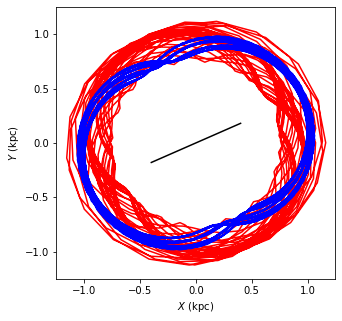

In [402]:
short_bar_orbit3=Orbit(vxvv=[1.,0.2,0.9,0.])
short_bar_orbit4=Orbit(vxvv=[1.,-0.15,0.9,0.])

short_bar_time=numpy.linspace(0,10./bovy_conversion.time_in_Gyr(vo,ro),1000)
rotation=(short_bar_time*-1.85)

short_bar_orbit3.integrate(short_bar_time,short_bar_pot,method='odeint')
short_bar_orbit4.integrate(short_bar_time,short_bar_pot,method='odeint')

sbx3=short_bar_orbit3.x(short_bar_time)*np.cos(rotation)-short_bar_orbit3.y(short_bar_time)*np.sin(rotation)
sby3=short_bar_orbit3.x(short_bar_time)*np.sin(rotation)+short_bar_orbit3.y(short_bar_time)*np.cos(rotation)
sbx4=short_bar_orbit4.x(short_bar_time)*np.cos(rotation)-short_bar_orbit4.y(short_bar_time)*np.sin(rotation)
sby4=short_bar_orbit4.x(short_bar_time)*np.sin(rotation)+short_bar_orbit4.y(short_bar_time)*np.cos(rotation)

plt.figure(figsize=(5,5))
plt.plot(sbx3,sby3,color='red')
plt.plot(sbx4,sby4,color='blue')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.xlabel(r'$X\ (\mathrm{kpc})$')
plt.ylabel(r'$Y\ (\mathrm{kpc})$')
plt.plot([-0.4,0.4],[-0.18,0.18],color='black')
plt.show()

You can see that while the blue orbit is stable and retains its shape over long timescales, the red orbit does not! This is known, that one alignment is stable while the other is not (e.g. See Fux 2000). Also note that over long timescales the blue orbit librates around the resonance, appearing aligned with the bar axis over multiple orbits!

But, are they actually resonant? We know from the equations above that the OLR should be where $\Omega_{\mathrm{p}}-\Omega_{\phi}-\Omega_{\mathrm{R}}/2=0$


Galpy can calculate actons, angles and frequencies with a variety of methods (see docs below). The Staeckel approximation is overkill here, but a useful example for other applications

In [408]:
from galpy.actionAngle import actionAngleStaeckel, estimateDeltaStaeckel, actionAngleIsochroneApprox

# The focal length of the potential local to the orbit 
delta=estimateDeltaStaeckel(MWPotential2014,1.,0.0000001,no_median=True)

# Set up the Staeckel object for the calculation
aAS = actionAngleStaeckel(pot=MWPotential2014,delta=delta)

# Calculate actions, angles and frequencies with [R,vR,vT,z,vz,phi]
# Note that it doesn't work when perfectly planar, so do small z & vz e.g. 0.0000001 
jR1,lz1,jz1,O_R1,O_phi1,O_z1,theta_R1,theta_phi1,theta_z1 = aAS.actionsFreqsAngles(1.,0.2,0.9, 0.00001,0.000001,0., delta=delta)
jR2,lz2,jz2,O_R2,O_phi2,O_z2,theta_R2,theta_phi2,theta_z2 = aAS.actionsFreqsAngles(1.,-0.15,0.9, 0.00001,0.000001,0., delta=delta)

In [546]:
# They're close to zero, but not exact, which is what I'd expect given my guesswork!

print(1.85-O_phi1-O_R1/2)
print(1.85-O_phi2-O_R2/2)

[-1.78117298e-05]
[-1.78117254e-05]


In addition, these are the actions calculated in the ${\it axisymmetric}$ potential, so they are not the ${\it true}$ actions. They are generally good enough to get close to the right answer for simplisic applications. (For a rigidly rotating pattern you can move to 'fast' and 'slow' actions, but we don't have time to cover that here. See Binney & Tremaine for some discussion)


However, because the resonances are a relation between the orbital frequencies of the stars, and the rigidly rotating bar pattern, if the potential changes, so do the frequencies, and so do the resonances:

Let's redo the same orbits in the heavier MWPotential2014_heavy:

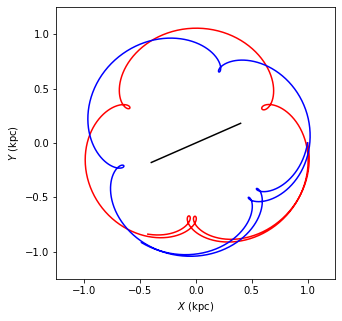

In [551]:
short_bar_pot_heavy = [MWPotential2014_heavy,short_bar]

short_bar_orbit5=Orbit(vxvv=[1.,0.2,0.9,0.])
short_bar_orbit6=Orbit(vxvv=[1.,-0.15,0.9,0.])

short_bar_time=numpy.linspace(0,0.5/bovy_conversion.time_in_Gyr(vo,ro),1000)
rotation=(short_bar_time*-1.85)

short_bar_orbit5.integrate(short_bar_time,short_bar_pot_heavy,method='odeint')
short_bar_orbit6.integrate(short_bar_time,short_bar_pot_heavy,method='odeint')

# We'll just plot the rotating frame this time
sbx5=short_bar_orbit5.x(short_bar_time)*np.cos(rotation)-short_bar_orbit5.y(short_bar_time)*np.sin(rotation)
sby5=short_bar_orbit5.x(short_bar_time)*np.sin(rotation)+short_bar_orbit5.y(short_bar_time)*np.cos(rotation)
sbx6=short_bar_orbit6.x(short_bar_time)*np.cos(rotation)-short_bar_orbit6.y(short_bar_time)*np.sin(rotation)
sby6=short_bar_orbit6.x(short_bar_time)*np.sin(rotation)+short_bar_orbit6.y(short_bar_time)*np.cos(rotation)

plt.figure(figsize=(5,5))
plt.plot(sbx5,sby5,color='red')
plt.plot(sbx6,sby6,color='blue')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.xlabel(r'$X\ (\mathrm{kpc})$')
plt.ylabel(r'$Y\ (\mathrm{kpc})$')
plt.plot([-0.4,0.4],[-0.18,0.18],color='black')
plt.show()

Now it's almost a 3:1, just from changing the halo potential! 


$\textbf{Exercise: But are they stable, and are they resonant?}$
 - Why don't you check the freqencies from the equations above? 
 - You can integrate it further in time to see what happens. Before you do, what do you expect?

In [505]:
# Calculate actions
# Check frequencies compared to the equations above!
# Integrate further

Regardless of what you found, we would not expect the 3:1 resonance to be strong in a bar with a pure $m=2$ component

When doing a fourier decomposition on real bars in nature or simulation we find they have a range of structure, and are rarely pure $m=2$ (e.g. Buta 2006).

But, the even fourier components are usually much stronger than the odd components owing to the bar symmetry. So, let's construct a bar with more complex morphology with the cosmphi disc potential. Let's do $m=4$ which is (usually/always?) the second strongest 

(https://docs.galpy.org/en/latest/reference/potentialcosmphidisk.html)

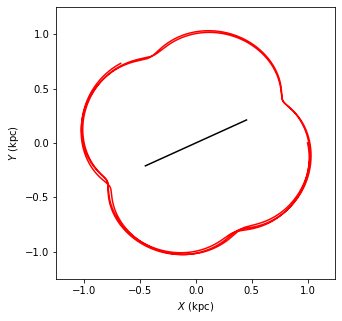

In [511]:
from galpy.potential import CosmphiDiskPotential,SolidBodyRotationWrapperPotential,DehnenSmoothWrapperPotential

omega=1.4 
length=4.
strength=1.

# This is the base m=2 component for the bar, but we could recreate it with the cosmphi potential below too
dp= DehnenBarPotential(omegab=omega,rb=length/8.,Af=(strength/75.),tform=tform,tsteady=tsteady,barphi=angle)

# Now we add a m=4 fourier potential component. 
# We then wrap it with a smooth growth wrapper, and then a rotating potential wrapper
cosm4= SolidBodyRotationWrapperPotential(\
           pot=DehnenSmoothWrapperPotential(\
                pot=CosmphiDiskPotential(amp=0.05,m=4.,phib=angle,p=-5.,rb=length/8.),tform=dp.tform()),omega=omega)#

m4_bar_pot= [MWPotential2014,dp,cosm4]

# Jason only had time to make 1 (almost) resonant orbit... Will try and fix before school
m4_bar_orbit1=Orbit(vxvv=[1.,0.1,0.9553,0.])
#m4_bar_orbit2=Orbit(vxvv=[1.,0.1,0.9553,0.])

m4_bar_time=numpy.linspace(0,1.62/bovy_conversion.time_in_Gyr(vo,ro),10000)

m4_bar_orbit1.integrate(m4_bar_time,m4_bar_pot,method='odeint')
#m4_bar_orbit2.integrate(m4_bar_time,m4_bar_pot,method='odeint')

deg=(m4_bar_time*-1.4)
b4x3=m4_bar_orbit1.x(m4_bar_time)*np.cos(deg)-m4_bar_orbit1.y(m4_bar_time)*np.sin(deg)
b4y3=m4_bar_orbit1.x(m4_bar_time)*np.sin(deg)+m4_bar_orbit1.y(m4_bar_time)*np.cos(deg)
#b4x4=m4_bar_orbit2.x(m4_bar_time)*np.cos(deg)-m4_bar_orbit2.y(m4_bar_time)*np.sin(deg)
#b4y4=m4_bar_orbit2.x(m4_bar_time)*np.sin(deg)+m4_bar_orbit2.y(m4_bar_time)*np.cos(deg)
plt.figure(figsize=(5,5))
plt.plot(b4x3,b4y3,color='red')
#plt.plot(b4x4,b4y4,color='blue')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.xlabel(r'$X\ (\mathrm{kpc})$')
plt.ylabel(r'$Y\ (\mathrm{kpc})$')
plt.plot([-0.453,0.453],[-0.211,0.211],color='black')
plt.show()


And voila, a 4:1 orbit!

$\textbf{Example: Backwards intergation}$

Often, we're more interested in a distribution of orbits instead of the parameters/morphology of a single one

A simple way to visualise the local velocity distribution without integrating a large number of orbits is the so called 'Backwards integration technique' (Dehnen 2000, AJ, 119, 800).

Essentially this involves integrating a grid of orbits in phase space backwards in time in the desired potential, and then assigning them present day 'weights' based on the density at the location they end up at in the 'past'. 

This works well for a quick visualisation of what you expect today, but completely breaks down in the presence of chaos! Still, as the number of particles needed to resolve local phase space is high in any particle based simulation, this is a useful tool, providing you remember the caveats

In [589]:
from galpy.df import evolveddiskdf
from galpy.df import dehnendf
from scipy import ndimage as nd

# We'll make a new bar here, this is the short_bar again for the discussion below
omega= 1.85 # Pattern speed of the bar 
angle=25./180.*numpy.pi # Bar Angle
length=3.5

# Initiate potentials
dp= DehnenBarPotential(omegab=omega,rb=length/8.,Af=(1./75.),tform=tform,tsteady=tsteady,barphi=angle)
lhp=LogarithmicHaloPotential(normalize=1.)
pot= [lhp,dp]

# Initiate Dehnen distribution function (Dehnen 1999, AJ, 118, 1201)
dfc= dehnendf(beta=0.,correct=False,profileParams=(1./3.,1.,0.15))

# Integrate backwards following (Dehnen 2000, AJ, 119, 800)
edf= evolveddiskdf(dfc,pot,to=dp.tform())

# Calculate the velocity field upon a grid (at R/R0=1, phi=0, at the present day)
mvr, grid= edf.meanvR(1.,phi=0.,deg=False,t=0.,grid=True,returnGrid=True,gridpoints=101)

And plot the resulting local velocity distribution for a system with the chosen potential

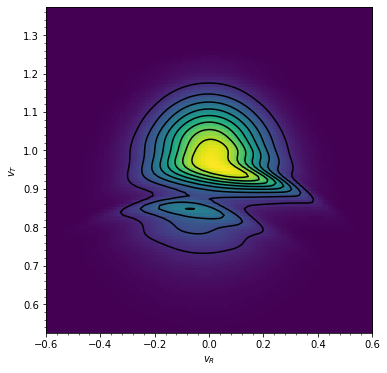

In [591]:
plt.figure(figsize=(6,6))
bovy_plot.bovy_dens2d(nd.gaussian_filter(grid.df[::-1].T,1.),
                      origin='lower',contours=True,xrange=[grid.vRgrid[0],grid.vRgrid[-1]],
                      yrange=[grid.vTgrid[0],grid.vTgrid[-1]],xlabel=r'$v_R$',ylabel=r'$v_T$',gcf=True,cmap='viridis')
bovy_plot._add_ticks()

Assuming you kept the parameters of the short bar above, you'll see a bimodal distribution with a weaker group in the lower left, and a sharp spikey bit going towards the right. This is caused by the 2:1 Outer Lindblad resonance. 

In the past, people have suggested this to be the origin of the division between the 'Hercules stream' and the main part of the distribution (e.g. Dehnen 2000). But recent more direct measurements of the bar pattern speed and length argue against this.

Here, the 'Hercules-like' group in the lower left is primarily composed of the 'red' orbits from 'Figure 1' above, and the sharp part is primarily composed of the 'blue' orbits (see Fragkoudi 2019 for a more thorough discussion)

$\textbf{Exercise: What do the other bars leave as imprints in the local kinematics?}$
- How do a long slow bar and a bar with m=4 and an intermediate pattern compare to the local observed kinematics?
- You can find the real $v_R-v_{\phi}$ plane in https://ui.adsabs.harvard.edu/abs/2018A%26A...616A..11G/abstract
- Can you relate the orbit structure above to the morphology of the velocity distribution?

$\textbf{Stretch goal exercise: What about the spiral arms?}$
- Try adding a density wave spiral arm potential from galpy's list of potentials
- Try adding transient winding spirals (see https://ui.adsabs.harvard.edu/abs/2018MNRAS.481.3794H/abstract for what is hopefully an understadable example!)
- How do they compare?

$\textbf{The end. You made it! Hopefully some of this was useful/interesting to you (if not I apologise!)}$
$\textbf{Now you should:}$
- Go back through and pick one or more of those stretch goal exercises!
- Assist your peers!
- (Go for lunch?)